In [1]:
import numpy as np
import matplotlib.pyplot as plt
from funciones import *

# --- PREGUNTA 1 ---

In [2]:
# --- Parámetros del sistema ---
L  = 1.0                
E  = 210e9               
I  = 1.0e6       
EI = E*I
q  = 1000.0              
P  = 2000.0               

## Forma analítica 

Reacciones teóricas: RA=RB=1.500000e+03 N
Momentos teóricos  : MA=MB=-3.333333e+02 N·m
Flecha máx (teo) en L/2: w = -6.200397e-17 m (negativa = hacia abajo)


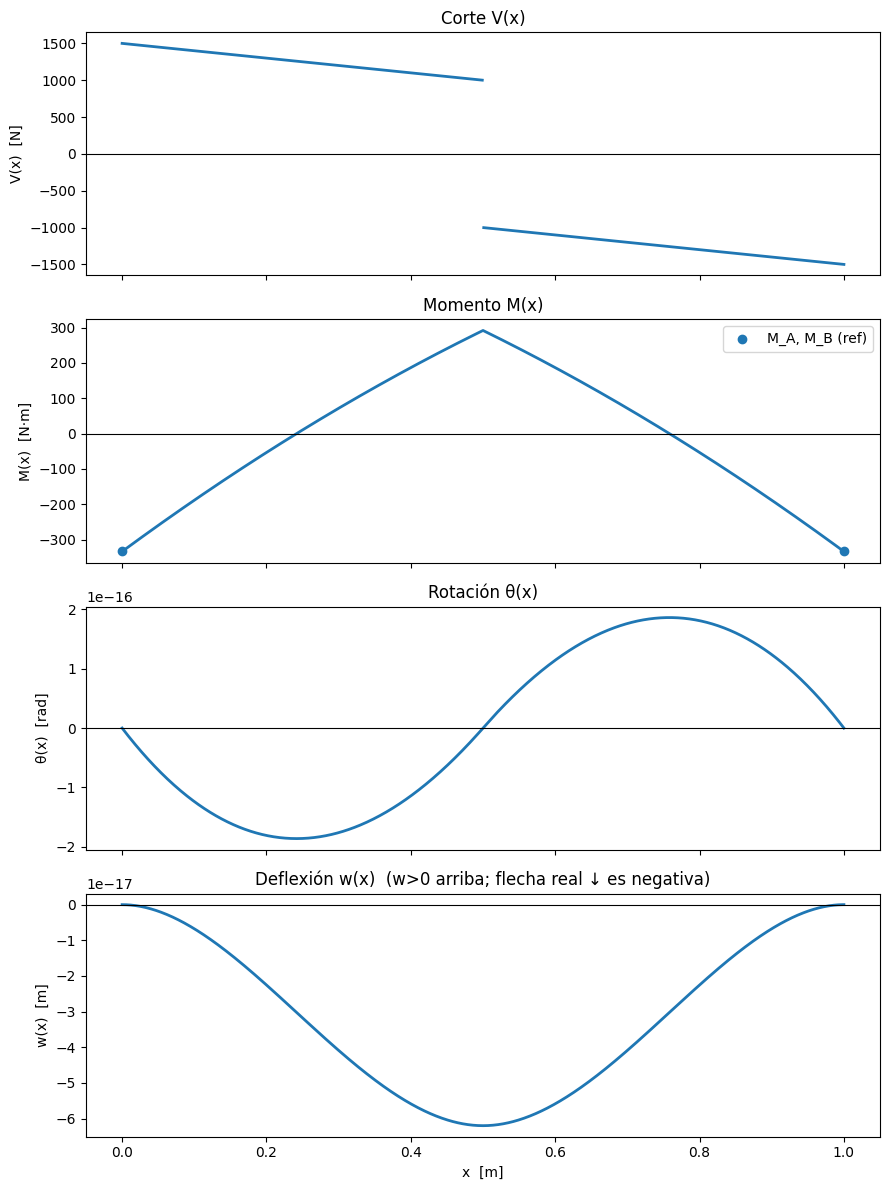

In [3]:
# ---------- Campos analíticos (fixed-fixed) ----------
def V_q(x, L, q):
    # Corte por carga uniforme (algebraico)
    return 0.5*q*(L - 2.0*x)

def M_q(x, L, q):
    # Momento por carga uniforme (algebraico)
    # Equivalente a: q/2*(L*x - x**2) - q*L**2/12
    return -(q/12.0)*(L**2 - 6.0*L*x + 6.0*x**2)

def V_P(x, L, P):
    # Corte por carga puntual centrada (salto -P en L/2)
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    out[x <  L/2] = +0.5*P
    out[x >  L/2] = -0.5*P
    out[x == L/2] = np.nan  # discontinuidad (opcional para graficar)
    return out

def M_P(x, L, P):
    # Momento por carga puntual centrada (por tramos)
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    left  = (x <= L/2)
    right = (x >= L/2)
    out[left]  = -P*L/8.0 + 0.5*P*x[left]
    out[right] = +3.0*P*L/8.0 - 0.5*P*x[right]
    return out

def w_q(x, L, q, EI):
    # Deflexión por q: w>0 arriba; flecha real hacia abajo -> negativa
    return -(q/(24.0*EI))*x**2*(L - x)**2

def theta_q(x, L, q, EI):
    # Rotación = dw/dx
    return -(q/(12.0*EI))*x*(L - x)*(L - 2.0*x)

def w_P(x, L, P, EI):
    # Deflexión por P centrada (por tramos)
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    left  = (x <= L/2)
    right = (x >= L/2)
    out[left]  = -(P/(48.0*EI))*x[left]**2*(3.0*L - 4.0*x[left])
    out[right] = -(P/(48.0*EI))*(-L**3 + 6.0*L**2*x[right] - 9.0*L*x[right]**2 + 4.0*x[right]**3)
    return out

def theta_P(x, L, P, EI):
    # Rotación por P centrada (por tramos)
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    left  = (x <= L/2)
    right = (x >= L/2)
    out[left]  = -(P/(8.0*EI))*x[left]*(L - 2.0*x[left])
    out[right] = -(P/(8.0*EI))*(L**2 - 3.0*L*x[right] + 2.0*x[right]**2)
    return out

# Totales por superposición
def V_total(x, L, q, P):
    Vt = V_q(x, L, q) + V_P(x, L, P)
    return Vt

def M_total(x, L, q, P):
    Mt = M_q(x, L, q) + M_P(x, L, P)
    return Mt

def w_total(x, L, q, P, EI):
    return w_q(x, L, q, EI) + w_P(x, L, P, EI)

def theta_total(x, L, q, P, EI):
    return theta_q(x, L, q, EI) + theta_P(x, L, P, EI)

# Discretización
n  = 1001
x  = np.linspace(0.0, L, n)

# Campos
V = V_total(x, L, q, P)
M = M_total(x, L, q, P)
th = theta_total(x, L, q, P, EI)
w = w_total(x, L, q, P, EI)

# Reacciones y momentos de apoyo (referencias cerradas)
R_ref = 0.5*(q*L + P)
M_ref = -(q*L**2/12.0 + P*L/8.0)
print(f"Reacciones teóricas: RA=RB={R_ref:.6e} N")
print(f"Momentos teóricos  : MA=MB={M_ref:.6e} N·m")
print(f"Flecha máx (teo) en L/2: w = {-(q*L**4/384.0 + P*L**3/192.0)/EI:.6e} m (negativa = hacia abajo)")

# Gráficos
fig, axs = plt.subplots(4, 1, figsize=(9, 12), sharex=True)
axs[0].plot(x, V, lw=2)
axs[0].axhline(0, color='k', lw=0.8)
axs[0].set_ylabel("V(x)  [N]")
axs[0].set_title("Corte V(x)")
axs[1].plot(x, M, lw=2)
axs[1].axhline(0, color='k', lw=0.8)
axs[1].set_ylabel("M(x)  [N·m]")
axs[1].set_title("Momento M(x)")
axs[1].scatter([0, L], [M_ref, M_ref], zorder=3, label="M_A, M_B (ref)")
axs[1].legend(loc="best")
axs[2].plot(x, th, lw=2)
axs[2].axhline(0, color='k', lw=0.8)
axs[2].set_ylabel("θ(x)  [rad]")
axs[2].set_title("Rotación θ(x)")
axs[3].plot(x, w, lw=2)
axs[3].axhline(0, color='k', lw=0.8)
axs[3].set_xlabel("x  [m]")
axs[3].set_ylabel("w(x)  [m]")
axs[3].set_title("Deflexión w(x)  (w>0 arriba; flecha real ↓ es negativa)")
plt.tight_layout()
plt.show()

## Elementos finitos

In [6]:
# Discretización
ne = 2

# ====== Malla ======
x, elems, Le = make_uniform_beam_mesh(L, ne)

# ====== Ensamble K y F ======
K, F = assemble_KF_beam(E, I, x, elems, q_uniform=q, pointloads=[(L/2, P)])

# ====== Condiciones de borde: empotramientos en x=0 y x=L ======
U, R, free, fixed = apply_fixed_ends_bc(K, F, N=x.size)

for n in [0, x.size - 1]:
    print(f"Nodo {n+1} (x={x[n]:.3f} m) -> Rv={R[2*n]:.2f} N, M={R[2*n+1]:.2f} N·m")

# ====== Post-proceso: fuerzas de extremo por elemento (V, M) locales ======
for e, (i, j) in enumerate(elems):
    u_e = np.array([U[2*i], U[2*i+1], U[2*j], U[2*j+1]])
    s_loc = element_end_forces_local(E, I, x[j]-x[i], u_e, q_uniform=q)
    Vi, Mi, Vj, Mj = s_loc  # [Fv_i, M_i, Fv_j, M_j]
    print(f"Elem {e+1}: V_i={Vi:.2f} N, M_i={Mi:.2f} N·m | V_j={Vj:.2f} N, M_j={Mj:.2f} N·m")

Nodo 1 (x=0.000 m) -> Rv=1500.00 N, M=333.33 N·m
Nodo 3 (x=1.000 m) -> Rv=1500.00 N, M=-333.33 N·m
Elem 1: V_i=1500.00 N, M_i=333.33 N·m | V_j=-1000.00 N, M_j=291.67 N·m
Elem 2: V_i=-1000.00 N, M_i=-291.67 N·m | V_j=1500.00 N, M_j=-333.33 N·m


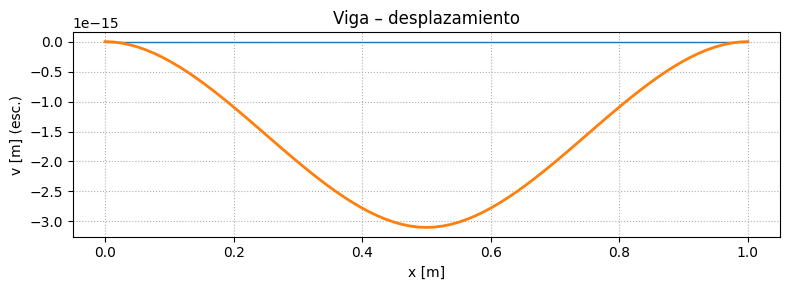

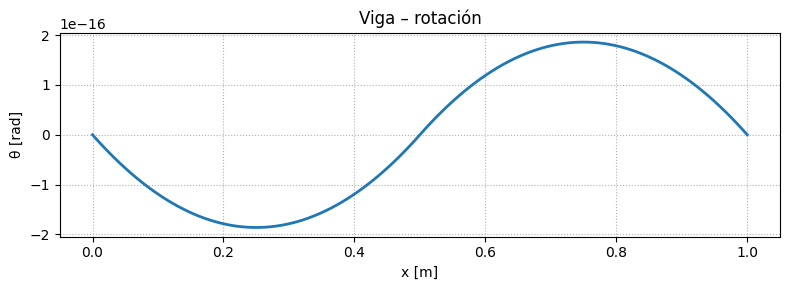

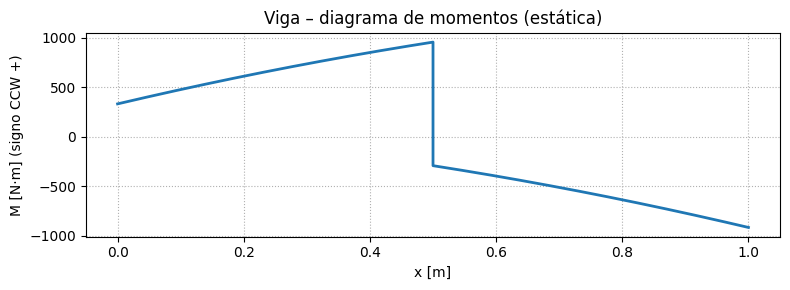

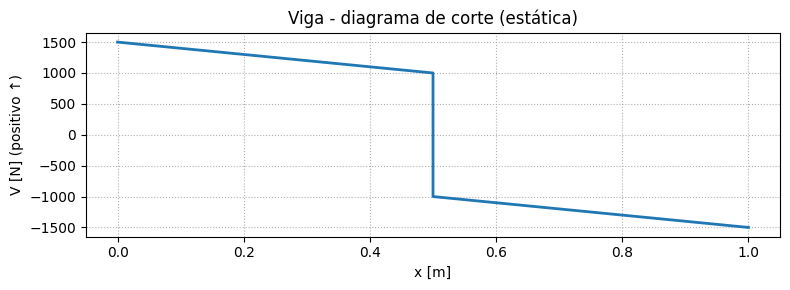

In [7]:
# ====== Gráfico de deformada ======
plot_deflection(x, elems, U, scale=50.0, nper=40)
plot_rotation_beam(x, elems, U, nper=60)
plot_moment_beam(x, elems, U, E, I, q_uniform=q, nper=120)
plot_shear_beam(x, elems, U, E, I, q_uniform=q, nper=120)